## Keras (frontend) & tensorflow (backend)

In [1]:
import os
import keras

os.environ["KERAS_BACKEND"] = "tensorflow"

## Loading mnist dataset

In [2]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# 60000 images of 28x28 dimension
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Let's display the first 10 images in the dataset.

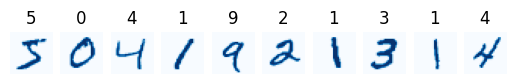

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="Blues")
    plt.title(y_train[i])
    plt.axis("off")

## Reshape inputs
Let's now reshape the data to have a single array with 28x28=784 pixels, so that we can feed it as an input for our siamese network.

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


## Normalization

Let's normalize each image to values between 0 and 1 via min-max normalization.

In [5]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

## Generating positive/negative pairs

Let's start by generating 60 000 positive pairs, and 60 000 negative pairs (120 000 pairs total) to train our siamese network.

In [6]:
import numpy as np

def generate_pairs(X, y):
    X_pairs, y_pairs = [], []

    for i in range(len(X)):
        label = y[i]

        # Positive pairs
        positive_label_index = np.random.choice(np.where(y == label)[0])
        X_pairs.append([X[i], X[positive_label_index]])
        y_pairs.append([0])

        # Negative pairs
        negative_label_index = np.random.choice(np.where(y != label)[0])
        X_pairs.append([X[i], X[negative_label_index]])
        y_pairs.append([1])

    # Braking alternate pos/neg
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)
    
    # Return array in shuffled order
    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [7]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


Let's do a little verification to see if the pairs were done correctly before proceeding in creating our siamese network.

In [8]:
def display_pairs(X, y, n_pairs, correct=None):
    plt.figure(figsize=(20,6))
    for i, (image1, image2) in enumerate(zip(X[:n_pairs, 0], X[:n_pairs, 1])):
        label = int(y[:n_pairs][i][0])
        title = "Positive" if label == 0 else "Negative"
        color = "lightseagreen"

        if correct is not None:
            title = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n_pairs][i][0] else "indianred"
        
        ax = plt.subplot(3, n_pairs, i+1)
        ax.text(
            1, -3, title, style="italic", bbox={"facecolor": color, "pad": 4}
        )

        plt.imshow(image1.reshape(28,28), cmap="Blues")
        plt.axis("off")

        ax = plt.subplot(3, n_pairs, i+1+n_pairs)
        plt.imshow(image2.reshape(28,28), cmap="Blues")
        plt.axis("off")

    plt.show()

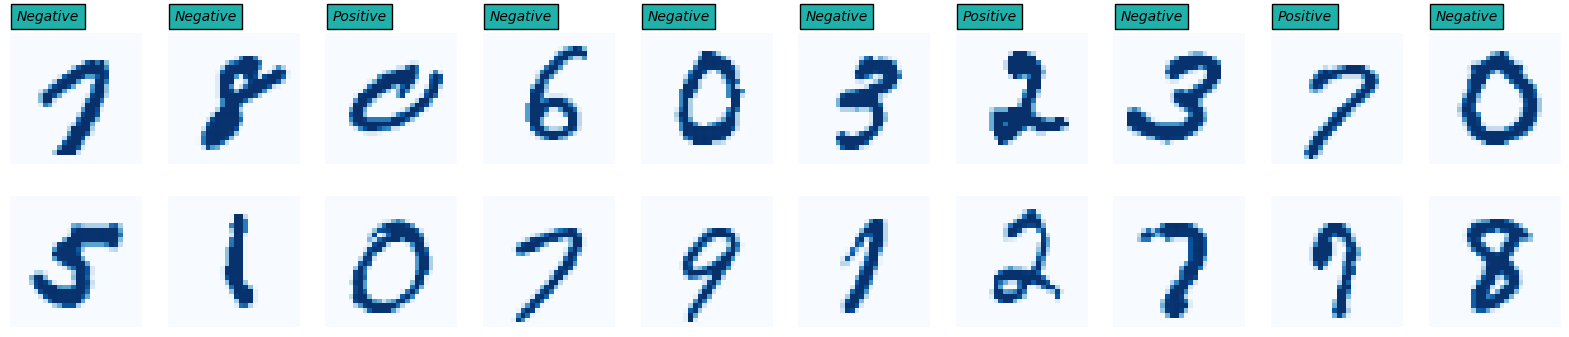

In [11]:
display_pairs(X_train_pairs, y_train_pairs, n_pairs=10)

## Building the model

Let's first defining the inputs for our pair of images.

In [12]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

Now, let's build the body of the siamese network

In [13]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(784,)),

        Dense(512, activation="relu"),
        Dense(256, activation="relu"),

        # Getting the raw embeddings, no activation
        # Small sized embeddings (Casual Project)
        Dense(128, activation=None),
    ]
)

Using the same network instance to share the same weights.

In [14]:
twin1, twin2 = network(input1), network(input2)

Defining a Lambda layer that calculates the Euclidean distance, and calculating the distance between embeddings.

In [15]:
from keras.layers import Lambda
from keras.ops import norm

def euclidean_distance(twins):
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)

In [16]:
distance = Lambda(euclidean_distance)([twin1, twin2])

All we need to do now is assemble the model together.

In [17]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)